# Reward Function Evaluation

This notebook simulates a 20-step contact collection process under three exploration strategies:

1. **No Contact** – No new points are added.
2. **Redundant Contact** – New points are added near existing ones (minimal exploration).
3. **Exploratory Contact** – New points are added in novel regions (encouraged behavior).

At each step, we:
- Generate the new accumulated point cloud `PC(t)`
- Compute the reward based on one of the reward functions
- Plot and save both the point cloud and reward curve

This helps visualize how each reward function responds to different exploration behaviors.


## Setup

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("..")
from reward_funcs import Reward_PointNet, Reward_ChamferDist, Reward_Voxel_Occupancy
from step1 import load_ply  # reuse your function
from step2 import farthest_point_sampling  # also reuse FPS

raw_pc_dir = os.path.join("..", "data", "shapenetcorev2_PC_2048", "raw")

pc_raw = load_ply(os.path.join(raw_pc_dir, "pc_0.ply"))  # example object
pc_raw = torch.tensor(pc_raw, dtype=torch.float32).cuda()

## Define Contact Simulation Strategies
Each function returns the new PC(t) based on the previous PC(t−1) and raw data.

In [2]:
def simulate_no_contact(pc_prev, pc_raw=None):
    return pc_prev.clone()

def simulate_redundant(pc_prev, pc_raw):
    from step2 import sample_redundant_from_raw
    redundant_pts = sample_redundant_from_raw(pc_raw.cpu().numpy(), pc_prev.cpu().numpy(), k=20)
    merged = torch.cat([pc_prev, torch.tensor(redundant_pts).float().cuda()], dim=0)
    return farthest_point_sampling(merged, 256)

def simulate_exploratory(pc_prev, pc_raw):
    from step3 import sample_exploratory
    exploratory_pts = sample_exploratory(pc_raw.cpu().numpy(), pc_prev.cpu().numpy(), k=20)
    merged = torch.cat([pc_prev, torch.tensor(exploratory_pts).float().cuda()], dim=0)
    return farthest_point_sampling(merged, 256)

Help functions of plotting.

In [3]:
def plot_pc(pc, step, strategy, save_dir="plots_pc"):
    os.makedirs(save_dir, exist_ok=True)
    pc_np = pc.cpu().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc_np[:, 0], pc_np[:, 1], pc_np[:, 2], s=4)
    ax.set_title(f"{strategy} - Step {step}")
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{strategy}_step{step:02d}.png"))
    plt.close()


## Simulate 20 Steps for 3 strategies
We’ll store:

* All reward values over time for each strategy

* PC plots per step for visualization

In [4]:
strategies = {
    "no_contact": simulate_no_contact,
    "redundant": simulate_redundant,
    "exploratory": simulate_exploratory,
}

reward_fns = {
    "PointNet": Reward_PointNet,
    "Chamfer": Reward_ChamferDist,
    "Voxel": Reward_Voxel_Occupancy,
}

# initialize reward records
reward_history = {rname: {sname: [] for sname in strategies} for rname in reward_fns}

# initialize starting PC
from step1 import sample_nearest
pc0_np = sample_nearest(pc_raw.cpu().numpy(), 256)
pc0 = torch.tensor(pc0_np, dtype=torch.float32).cuda()

for strategy_name, sim_fn in strategies.items():
    pc_prev = pc0.clone()
    for step in range(20):
        pc_new = sim_fn(pc_prev, pc_raw)

        # Simulate dummy contact (repeating a subset of points with dummy forces)
        contact_points = pc_new[:20]
        dummy_force = torch.ones_like(contact_points) * 2.0
        contact = torch.cat([contact_points, dummy_force], dim=1)  # [20, 6] → fake contact [x y z fx fy fz]

        # Evaluate all reward functions
        for rname, rfunc in reward_fns.items():
            r = rfunc(contact, pc_new, pc_prev)
            reward_history[rname][strategy_name].append(r.item())

        plot_pc(pc_new, step, strategy_name)
        pc_prev = pc_new.clone()


## Plot Reward Curves

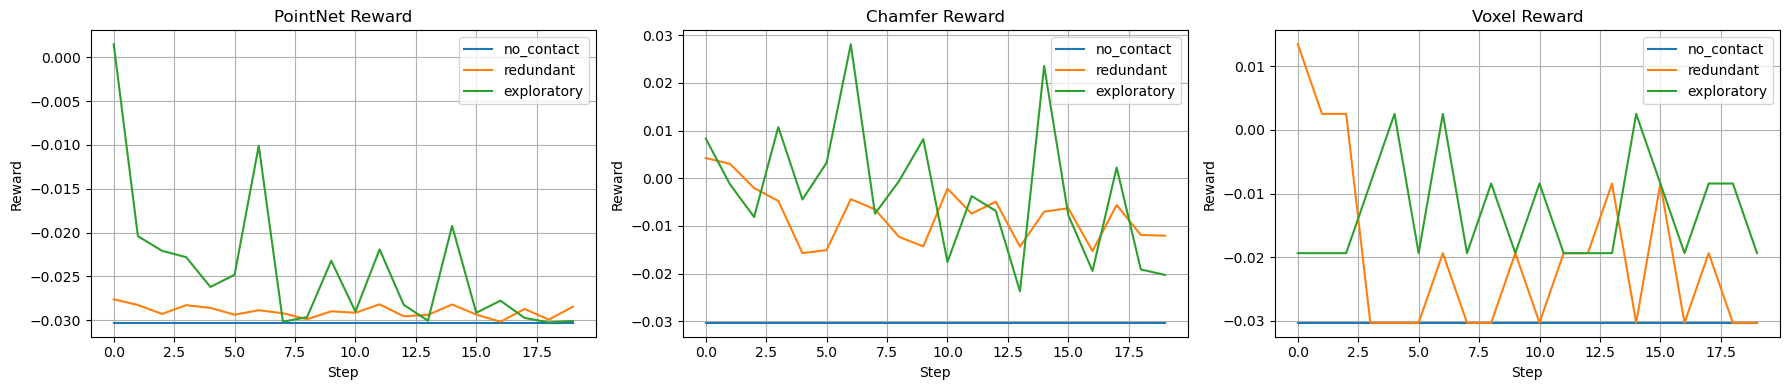

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, (rname, results) in enumerate(reward_history.items()):
    ax = axes[i]
    for sname, rewards in results.items():
        ax.plot(rewards, label=sname)
    ax.set_title(f"{rname} Reward")
    ax.set_xlabel("Step")
    ax.set_ylabel("Reward")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig("reward_comparison.png")
plt.show()
